In [45]:
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [46]:
def make_basis(n):
    basis=list(it.product([-1/2,1/2],repeat=n))
    inv={v:k for k,v in enumerate(basis)}
    return basis,inv

def get_bonds(width, height):
    if width%2!=0 or height%2!=0:
        raise ValueError("width and height must be even")
    bonds=[]
    for i in range(width):
        for j in range(height):
            i2,j2=(i+1)%width,j
            bonds.append((i+j*width,i2+j2*width,"j2"))
            i2,j2=i,(j+1)%height
            bonds.append((i+j*width,i2+j2*width,("j1" if j%2==0 else "j2")))
    return bonds

def make_H(width, height, j1):
    basis,inv=make_basis(width*height)
    bonds=get_bonds(width,height)
    rows=[]
    cols=[]
    data=[]
    for c,ket in enumerate(basis):
        diag=0
        for i,j,kind in bonds:
            #diagonal term
            if kind=="j1":
                diag+=ket[i]*ket[j]*j1
            elif kind=="j2":
                diag+=ket[i]*ket[j]
            #off-diagonal term
            if ket[i]!=ket[j]:
                bra=list(ket)
                bra[i],bra[j]=bra[j],bra[i]
                r=inv[tuple(bra)]
                rows.append(r)
                cols.append(c)
                data.append((j1 if kind=="j1" else 1)/2)
        rows.append(c)
        cols.append(c)
        data.append(diag)
    return sp.sparse.csr_matrix((data,(rows,cols)),shape=(len(basis),len(basis)))
def make_M(width, height):
    basis,inv=make_basis(width*height)
    rows=[]
    cols=[]
    data=[]
    for c,ket in enumerate(basis):
        value=0
        for x in range(width):
            for y in range(height):
                value+=ket[x+y*width]*(-1)**(x+y)
        rows.append(c)
        cols.append(c)
        data.append(np.abs(value))
    return sp.sparse.csr_matrix((data,(rows,cols)),shape=(len(basis),len(basis)))  


In [47]:
make_H(2,4,1)

<256x256 sparse matrix of type '<class 'numpy.float64'>'
	with 1792 stored elements in Compressed Sparse Row format>

In [48]:
def staggered_magnetization(width, height, beta, j1):
    H=make_H(width,height,j1).todense()
    M=make_M(width,height).todense()
    eigvals,eigvecs=np.linalg.eigh(H)
    Z=np.sum(np.exp(-beta*eigvals))
    rho=np.exp(-beta*eigvals)/Z
    total=0
    for vec,r in zip(eigvecs.T,rho):
        total+=np.conjugate(vec)@M@vec.T*r
    return float(total)

/tmp/ipykernel_6154/84633176.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(total)


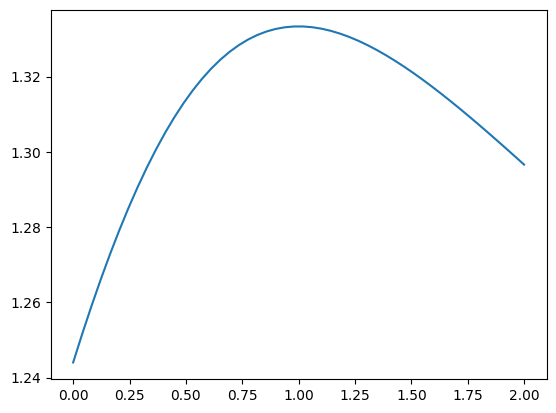

In [49]:
js=np.linspace(0,2,50)
ms=[staggered_magnetization(2,2,12,j) for j in js]
plt.plot(js,ms)


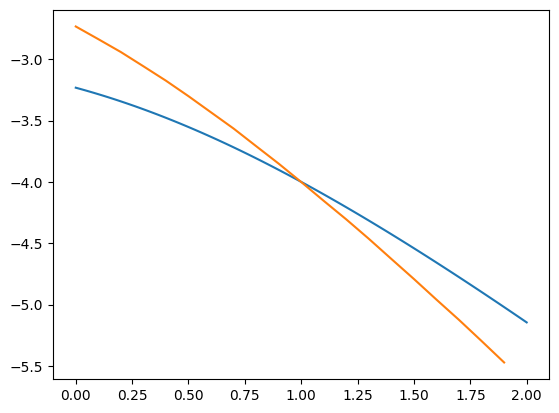

In [50]:
data=np.loadtxt("data.csv", delimiter=",")
data2=np.loadtxt("data2.csv", delimiter=",")
x=data[:,0]
x2=data2[:,0]
y=data[:,1]
y2=data2[:,1]
plt.plot(x2,y2)
plt.plot(x,y)


In [51]:
def energy(width, height, beta, j1):
    H=make_H(width,height,j1).todense()
    eigvals=np.linalg.eigvalsh(H)
    Z=np.sum(np.exp(-beta*eigvals))
    rho=np.exp(-beta*eigvals)/Z
    return sum(eigvals*rho)

[-3.232050807564088, -3.252939828919642, -3.2747897663588277, -3.2975982262327292, -3.3213612411370916, -3.3460733024839557, -3.371727405228957, -3.3983151039173065, -3.4258265790212064, -3.4542507123846193, -3.483575170471381, -3.5137864940315664, -3.5448701927593107, -3.5768108435111587, -3.609592190685082, -3.6431972474223704, -3.6776083963829085, -3.7128074889538416, -3.748775941876386, -3.78549483041068, -3.8229449772984663, -3.8611070369238827, -3.8999615742094282, -3.9394891379142187, -3.9796703281221175, -4.020485857816831, -4.061916608537839, -4.103943680195005, -4.146548435190541, -4.189712537055011, -4.233417983850138, -4.277647136625827, -4.322382743243626, -4.367607957894397, -4.413306356645924, -4.459461949357387, -4.506059188293393, -4.553082973761575, -4.600518657085392, -4.64835204120915, -4.696569379215241, -4.74515737101573, -4.794103158461711, -4.843394319094768, -4.893018858746208, -4.9429652031712195, -4.9932221888873, -5.043779053369481, -5.0946254247386795, -5.1

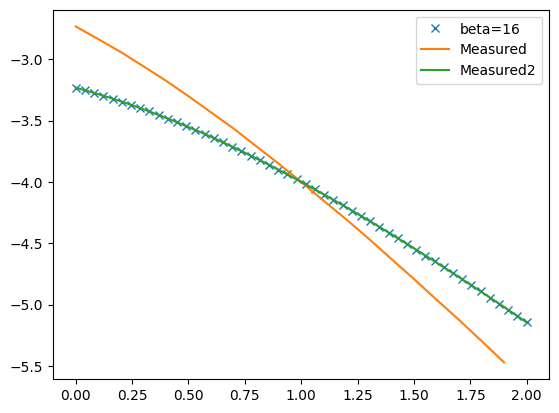

In [56]:
for beta in [16]:
    js=np.linspace(0,2,50)
    ms=[energy(2,2,beta,j1) for j1 in js]
    plt.plot(js,ms, "x",label=f"beta={beta}")
    print(ms)
plt.plot(x,y, label="Measured")
plt.plot(x2,y2,label="Measured2")
plt.legend()
plt.show()
    

In [53]:
make_H(2,2,0.001).todense()

matrix([[ 1.50050000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  5.00500000e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  2.77555756e-17,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  5.00500000e-01,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.0000000